In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("dataset.csv", encoding="latin", dtype={'CustomerID': str})

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Just by looking at the first 5 rows of our table, we can understand the structure and datatypes present in our dataset.<br>
We can notice that we will have to deal with time series data, integers and floats, and categorical, and text data.

Exploratory Data Analysis(EDA)<br>
Every data science project starts with EDA as we have to understand what do we have to deal with.<br>
I divide EDA into 2 types: visual and numerical. Let's start with numerical as the simple pandas method .describe() gives us a lot of useful information.

In [5]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Just a quick look at data with the .describe() method gives us a lot of space to think.<br>
We see negative quantities and prices, and we can see that not all records have CustomerID data.<br>
We can also see that the majority of transactions are for quantities from 3 to 10 items, majority of items have prices up to 5 pounds.<br>
We have a bunch of huge outliers we will have to deal with later.

Dealing with types<br>
.read_csv() method performs basic type check, but it doesn't do that perfectly.<br>
That's why it is much better to deal with data types in our dataframe before any modifications to prevent additional difficulties.<br>
Every pandas dataframe has an attribute .dtypes which will help us understand what we currently have and what data has to be casted to correct types.

In [6]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

If we have DateTime data it's better to cast it to DateTime type.<br>
We don't touch InvoiceNo for now as it seems like data in this column has not only numbers.<br>
We saw just the first 5 rows, while pandas during import scanned all the data and found that the type here is not numerical.

In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data  = data.set_index('InvoiceDate')

In [8]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom


Dealing with null values<br>
Next and very important step is dealing with missing values.<br>

Normally if you encounter null values in the dataset you have to understand nature of those null values and possible impact they could have on the model.<br>

There are few strategies that we can use to fix our issue with null values:
<br>
1. delete rows with null values
2. delete the feature with null values
3. impute data with mean or median values or use another imputing strategy (method .fillna())

In [9]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

CustomerID has too many null values and this feature cannot predict a lot so we can just drop it.<br>
It could be reasonable to create another feature "Amount of orders per customer".

In [10]:
data = data.drop(columns=['CustomerID'])

Let's check out what kind of nulls we have in Description:

In [11]:
data[data['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 11:52:00,536414,22139,NaN,56,0.0,United Kingdom
2010-12-01 14:32:00,536545,21134,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536546,22145,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536547,37509,NaN,1,0.0,United Kingdom
2010-12-01 14:34:00,536549,85226A,NaN,1,0.0,United Kingdom


The data in these rows is pretty strange as UnitPrice is 0, so these orders do not generate any sales.<br>
We can impute it with "UNKNOWN ITEM" at the moment and deal with those later during the analysis.

In [12]:
data['Description'] = data['Description'].fillna('UNKNOWN ITEM')
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64

Checking out columns separately<br>
It makes sense to go feature by feature and check what pitfalls we have in our data and also to understand our numbers better.<br>

Let's continue checking the Description column. Here we can see items that were bought most often.

In [13]:
data['Description'].value_counts().head()

Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: count, dtype: int64

Here we can see our best-selling products, items that appear in orders the most often.

To make it visually more appealing let's create a bar chart for 15 top items

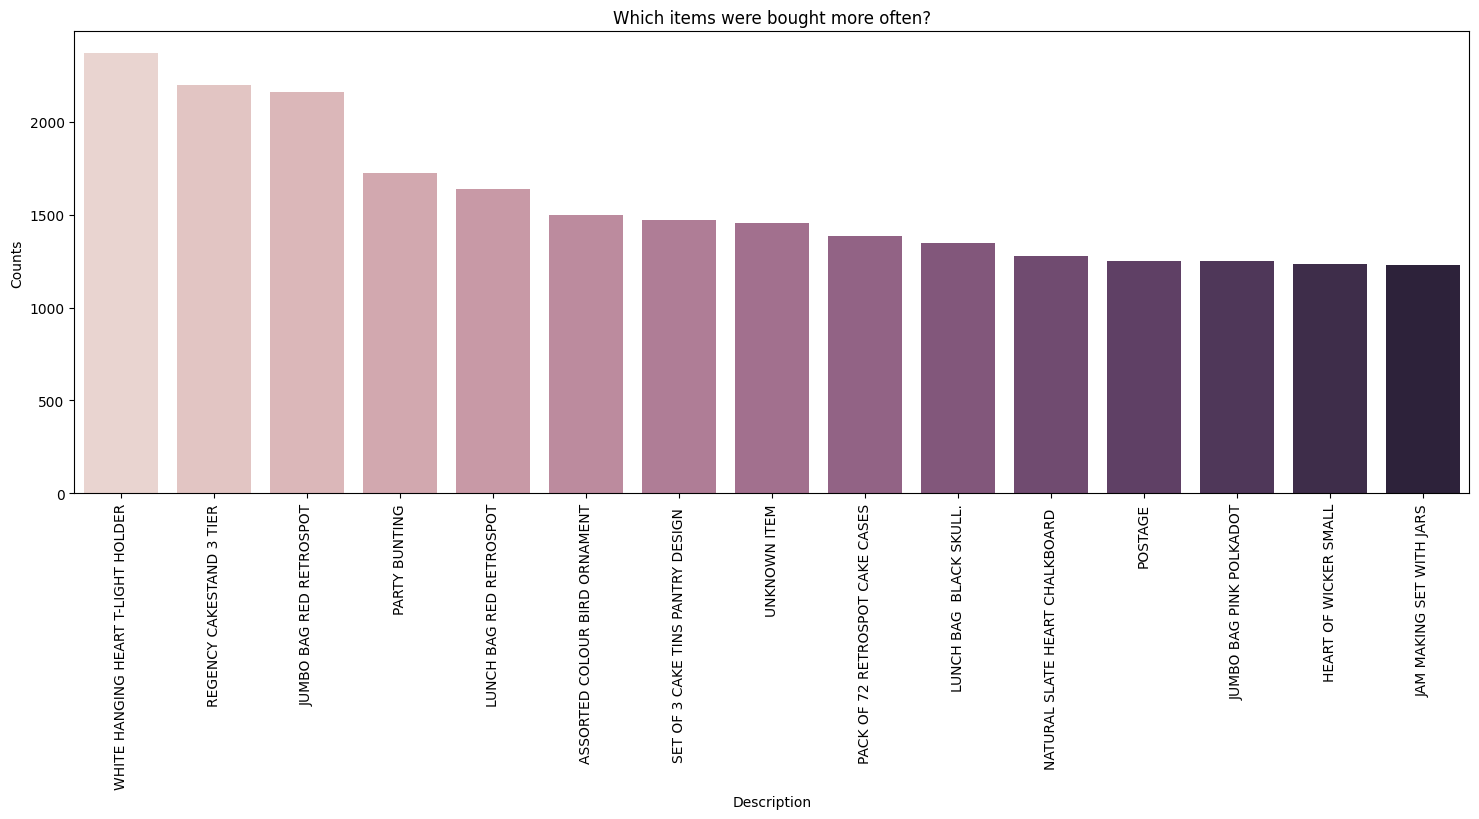

In [14]:
item_counts = data['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=item_counts.index, y=item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [15]:
data['Description'].value_counts().tail()

Description
Missing                                1
historic computer difference?....se    1
DUSTY PINK CHRISTMAS TREE 30CM         1
WRAP BLUE RUSSIAN FOLKART              1
PINK BERTIE MOBILE PHONE CHARM         1
Name: count, dtype: int64

We also notice from the above code that valid items are normally uppercase and non-valid or cancelations are in lowercase.

In [16]:
data[~data['Description'].str.isupper()]['Description'].value_counts().head()

Description
Manual                                572
BAG 125g SWIRLY MARBLES               304
BAG 250g SWIRLY MARBLES               252
3 TRADITIONAl BISCUIT CUTTERS  SET    240
POLYESTER FILLER PAD 40x40cm          193
Name: count, dtype: int64

A quick check of the case of letters in the Description says that there are some units with lowercase letters in their name and also that lowercase records are for canceled items.<br>
Here we can understand that data management in the store can be improved.

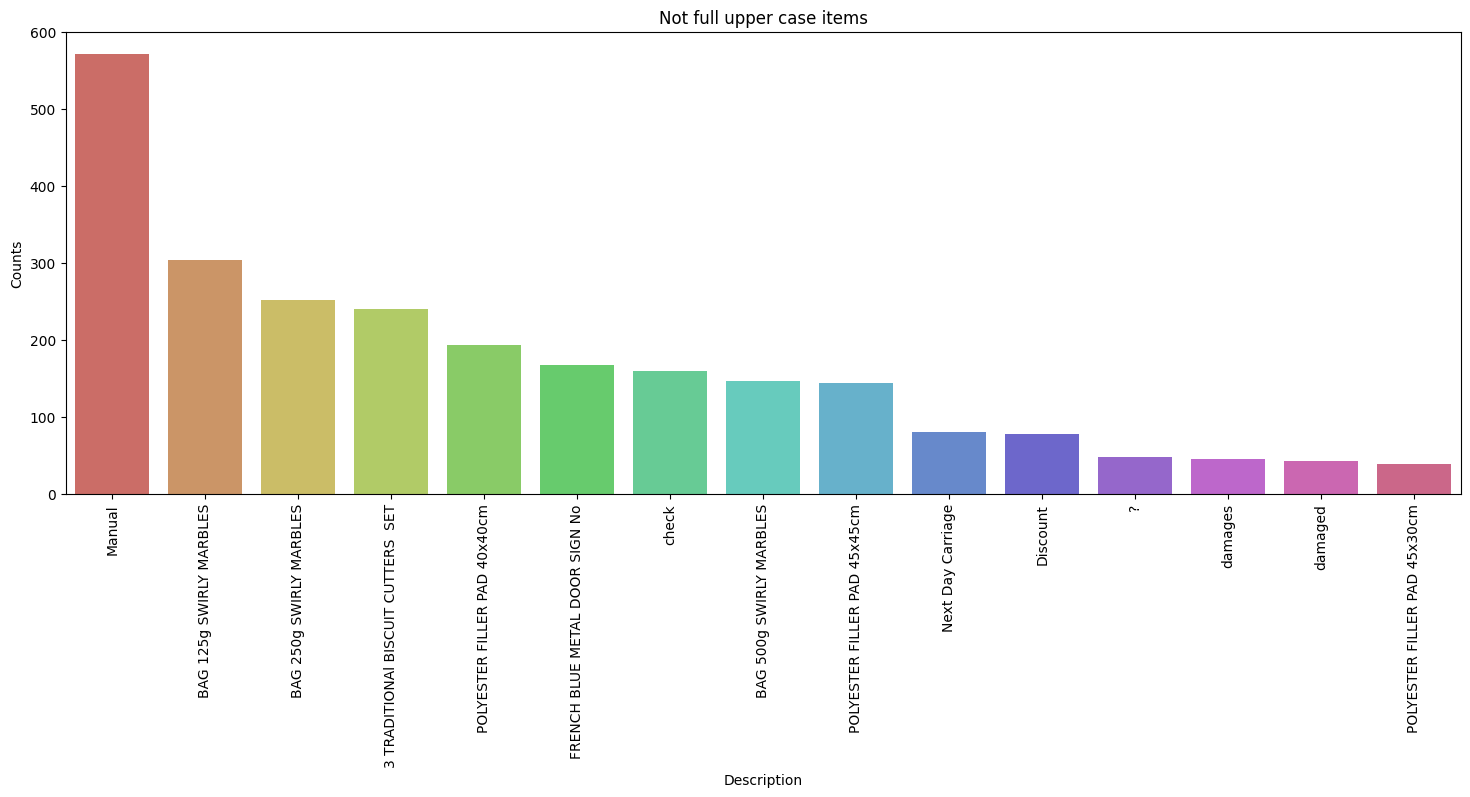

In [17]:
# Not full upper case items
lcase_counts = data[~data['Description'].str.isupper()]['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=lcase_counts.index, y=lcase_counts.values, palette=sns.color_palette("hls", 15))
plt.ylabel("Counts")
plt.title("Not full upper case items");
plt.xticks(rotation=90);

Checking out stoke codes looks like they are deeply correlated with descriptions - which makes perfect sense.

In [18]:
data['StockCode'].value_counts().head()

StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: count, dtype: int64

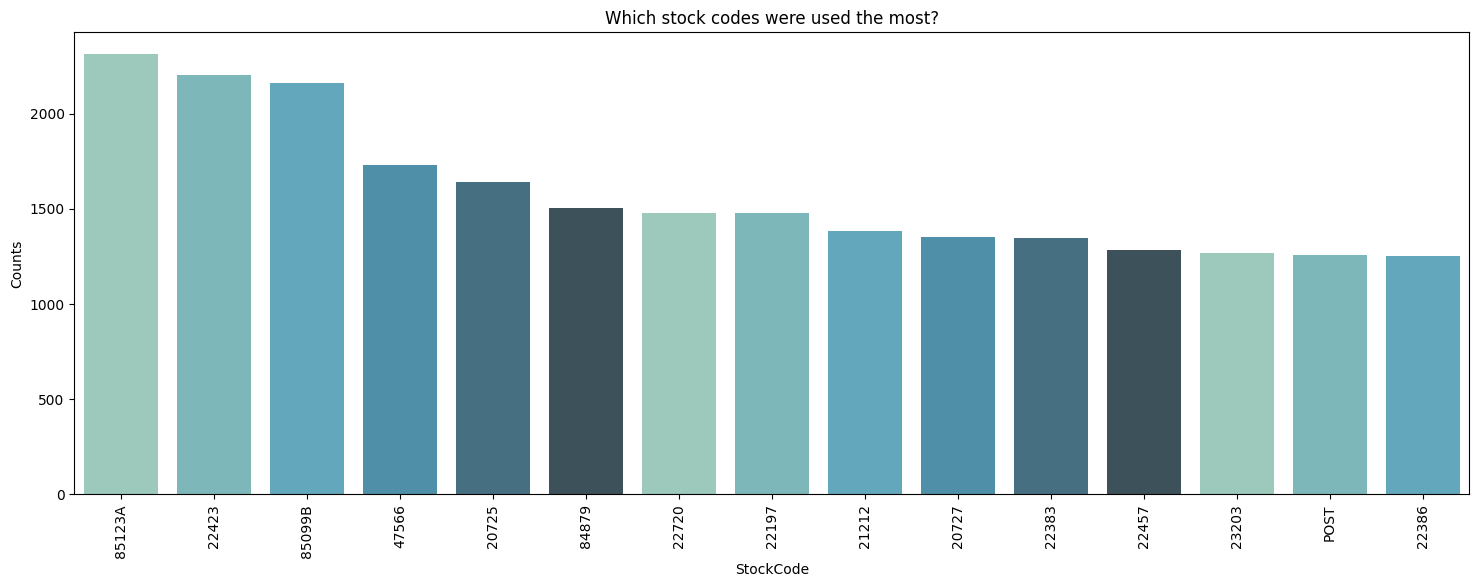

In [19]:
# Which stock codes were used the most?
stock_counts = data['StockCode'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=stock_counts.index, y=stock_counts.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("Which stock codes were used the most?");
plt.xticks(rotation=90);

Checking out also InvoiceNo feature

In [20]:
data['InvoiceNo'].value_counts().tail()

InvoiceNo
554023     1
554022     1
554021     1
554020     1
C558901    1
Name: count, dtype: int64

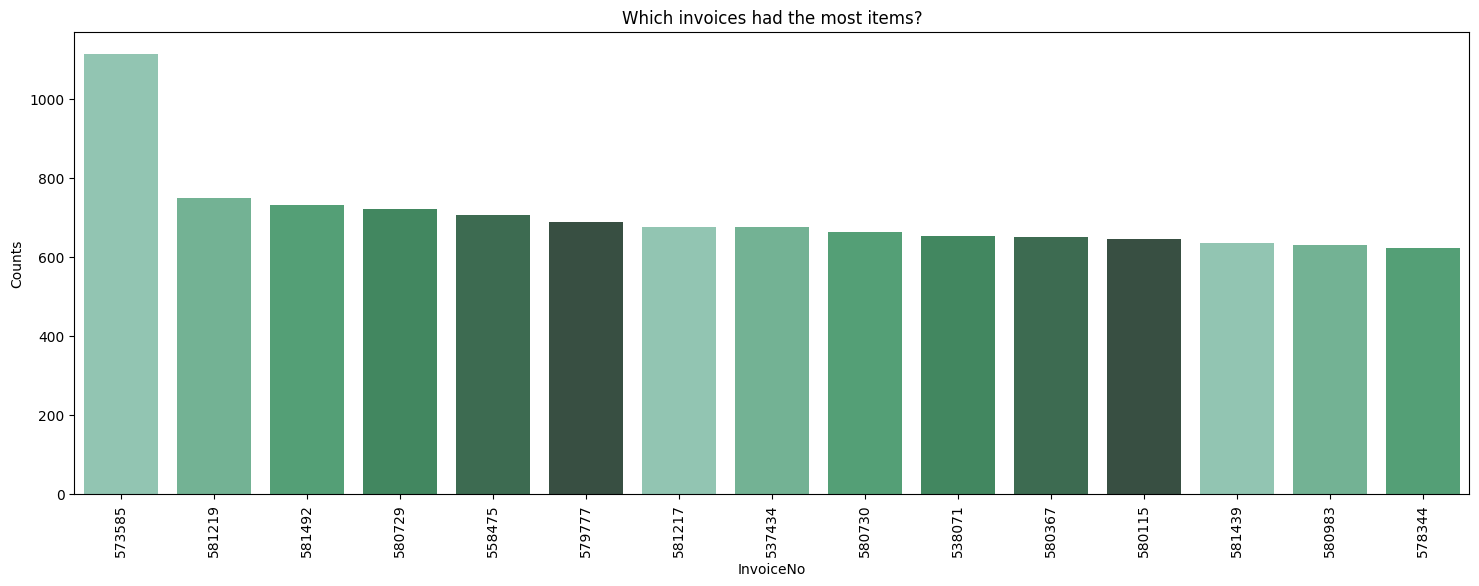

In [21]:
#  Which invoices had the most items?
inv_counts = data['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=inv_counts.index, y=inv_counts.values, palette=sns.color_palette("BuGn_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xticks(rotation=90);

In [22]:
data[data['InvoiceNo'].str.startswith('C')].describe()

,Quantity,UnitPrice
count,9288.000000,9288.000000
mean,-29.885228,48.393661
std,1145.786965,666.600430
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


Looks like Invoices that start with 'C' are the "Canceling"/"Returning" invoices. This resolves the mystery of negative quantities.<br>

Although, we should've gotten deeper into the analysis of those returns, for the sake of simplicity let's just ignore those values for the moment.<br>

We can actually start a separate project based on that data and predict the returning/canceling rates for the store.

In [23]:
data = data[~data['InvoiceNo'].str.startswith('C')]

In [24]:
data.describe()

,Quantity,UnitPrice
count,532621.000000,532621.000000
mean,10.239972,3.847621
std,159.593551,41.758023
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


During exploratory data analysis we can go back to the same operations and checks, just to understand how our actions affected the dataset.<br>

EDA is the series of repetitive tasks to understand better our data.<br>

Here, for example we get back to .describe() method to get an overall picture of our data after some manipulations.<br>

We still see negative quantities and negative prices, let's get into those records.<br>

In [25]:
# df[df['Quantity'] < 0]
data[data['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 16:50:00,536589,21777,UNKNOWN ITEM,-10,0.0,United Kingdom
2010-12-02 14:42:00,536764,84952C,UNKNOWN ITEM,-38,0.0,United Kingdom
2010-12-03 15:30:00,536996,22712,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536997,22028,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536998,85067,UNKNOWN ITEM,-6,0.0,United Kingdom


Here we can see that other "Negative quantities" appear to be damaged/lost/unknown items.<br>
Again, we will just ignore them for the sake of simplicity of analysis for this project.

In [26]:
data = data[data['Quantity']>0]
data.describe()

,Quantity,UnitPrice
count,531285.000000,531285.000000
mean,10.655262,3.857296
std,156.830323,41.810047
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


We also see negative UnitPrice, which is not normal as well.<br>
Let's check this out:

In [27]:
data[data['UnitPrice'] < 0].describe()

,Quantity,UnitPrice
count,2.0,2.00
mean,1.0,-11062.06
std,0.0,0.00
min,1.0,-11062.06
25%,1.0,-11062.06
50%,1.0,-11062.06
75%,1.0,-11062.06
max,1.0,-11062.06


In [28]:
data[data['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2011-08-12 14:51:00,A563186,B,Adjust bad debt,1,-11062.06,United Kingdom
2011-08-12 14:52:00,A563187,B,Adjust bad debt,1,-11062.06,United Kingdom


As there are just two rows, let's ignore them for the moment (the description gives us enough warnings, although we still need some context to understand it better)


In [29]:
data = data[data['UnitPrice'] > 0]
data.describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


As we have finished cleaning our data and removed all suspicious records we can start creating some new features for our model.<br>
Let's start with the most obvious one - Sales.<br>
We have quantities, we have prices - we can calculate the revenue.

VISUAL EDA

([0], [Text(0, 0, 'United Kingdom')])

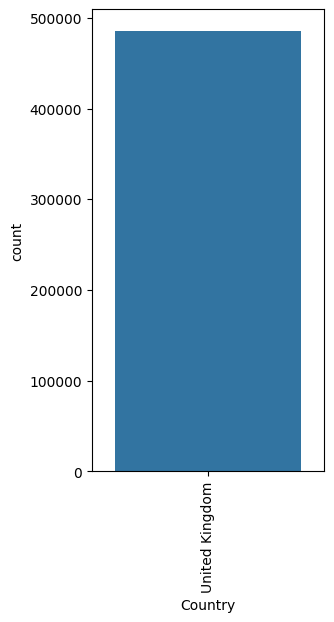

In [30]:
plt.figure(figsize=(3,6))
sns.countplot(x=data[data['Country'] == 'United Kingdom']['Country'])
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36],
 [Text(0, 0, 'France'),
  Text(1, 0, 'Australia'),
  Text(2, 0, 'Netherlands'),
  Text(3, 0, 'Germany'),
  Text(4, 0, 'Norway'),
  Text(5, 0, 'EIRE'),
  Text(6, 0, 'Switzerland'),
  Text(7, 0, 'Spain'),
  Text(8, 0, 'Poland'),
  Text(9, 0, 'Portugal'),
  Text(10, 0, 'Italy'),
  Text(11, 0, 'Belgium'),
  Text(12, 0, 'Lithuania'),
  Text(13, 0, 'Japan'),
  Text(14, 0, 'Iceland'),
  Text(15, 0, 'Channel Islands'),
  Text(16, 0, 'Denmark'),
  Text(17, 0, 'Cyprus'),
  Text(18, 0, 'Sweden'),
  Text(19, 0, 'Finland'),
  Text(20, 0, 'Austria'),
  Text(21, 0, 'Bahrain'),
  Text(22, 0, 'Israel'),
  Text(23, 0, 'Greece'),
  Text(24, 0, 'Hong Kong'),
  Text(25, 0, 'Singapore'),
  Text(26, 0, 'Lebanon'),
  Text(27, 0, 'United Arab Emirates'),
  Text(28, 0, 'Saudi Arabia'),
  Text(29, 0, 'C

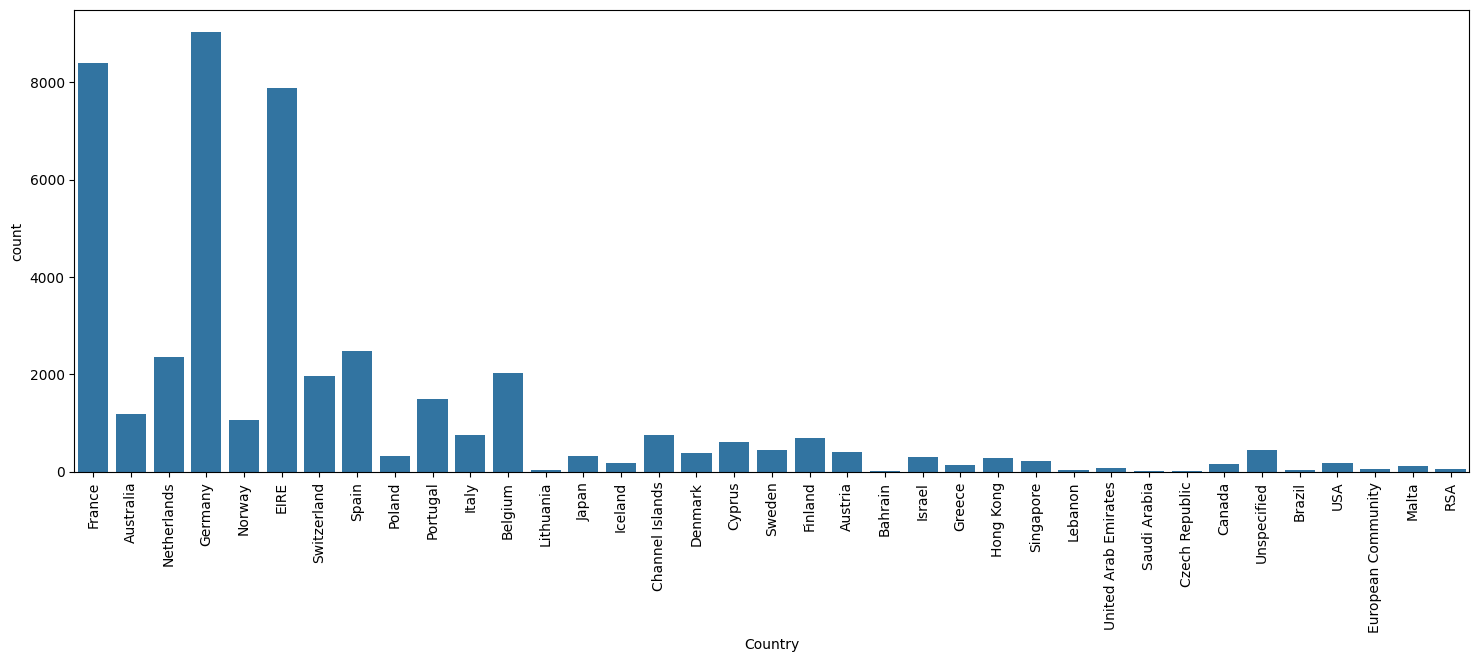

In [31]:
plt.figure(figsize=(18,6))
sns.countplot(x=data[data['Country'] != 'United Kingdom']['Country'])
plt.xticks(rotation=90)

In [32]:
uk_count = data[data['Country'] == 'United Kingdom']['Country'].count()
all_count = data['Country'].count()
uk_perc = uk_count/all_count
print(str('{0:.2f}%').format(uk_perc*100))

91.51%


From the above plots and calculations, we can see that the vast majority of sales were made in the UK and just 8.49% went abroad.<br>
We can say our dataset is skewed to the UK side.

Detecting outliers<br>
There are a few different methods to detect outliers:<br>

1. box plots,
2. using IQR,
3. scatter plot also works in some cases (and this is one of those).<br>

Detecting outliers using a scatter plot is pretty intuitive. You plot your data and remove data points that visually are definitely out of range. Like in the chart below:

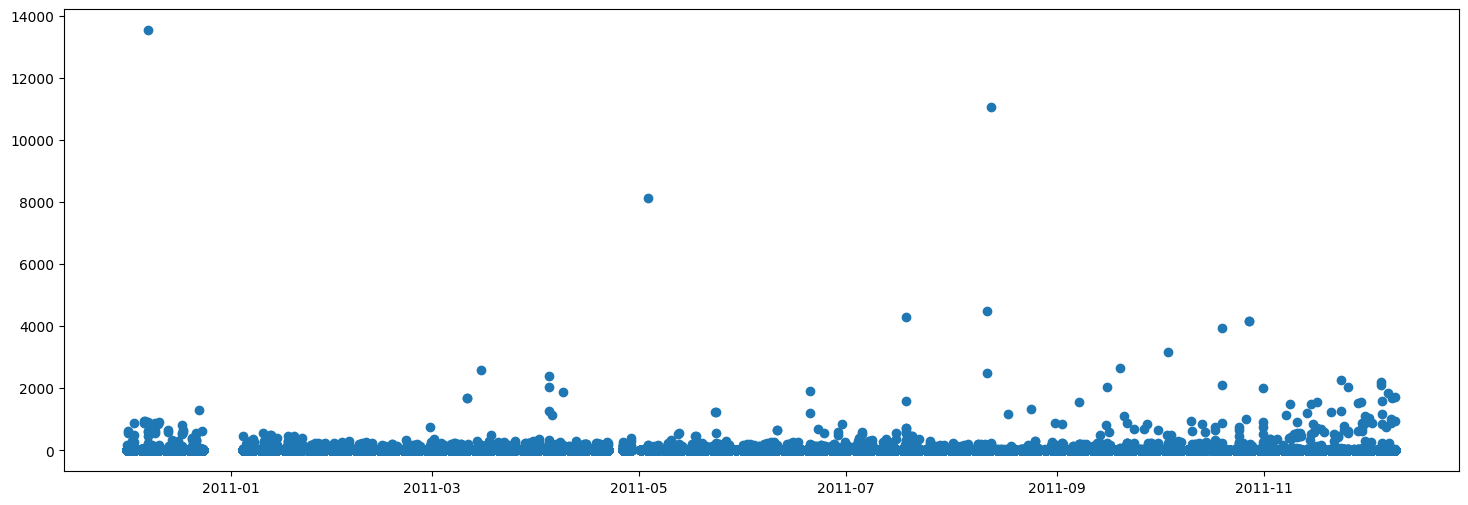

In [33]:
plt.figure(figsize=(18,6))
plt.scatter(x=data.index, y=data['UnitPrice'])

Remove obvious outliers:

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

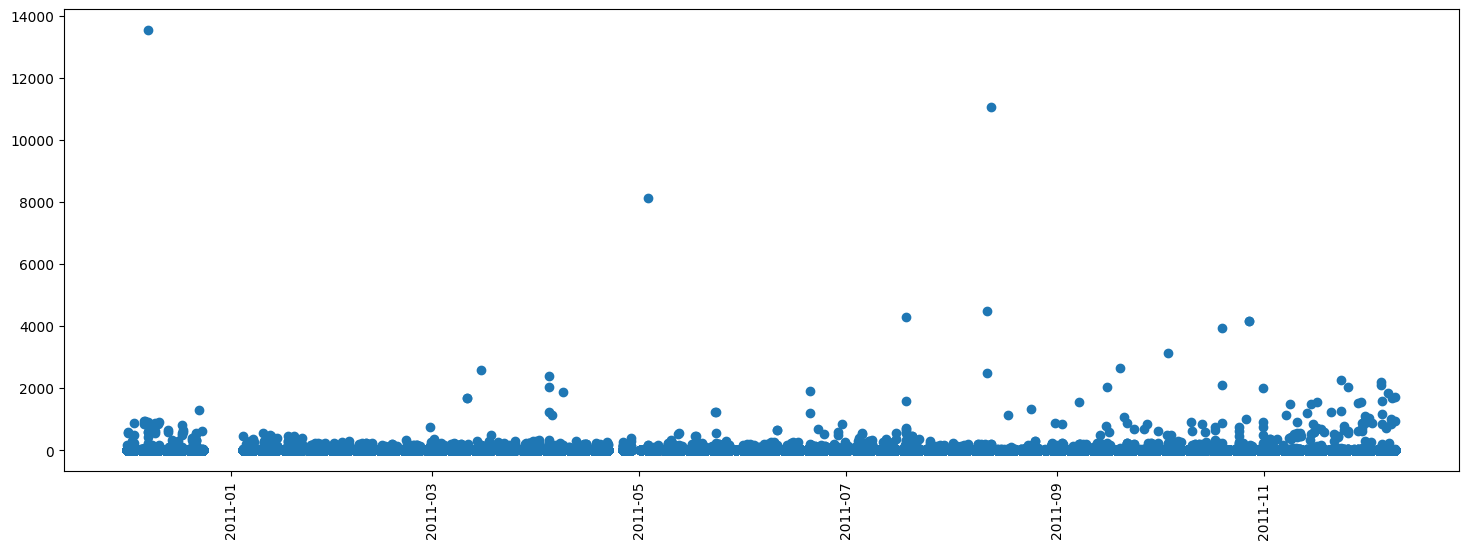

In [34]:
publish_display_data = data[data['UnitPrice'] < 25000]
plt.figure(figsize=(18,6))
plt.scatter(x=data.index, y=data['UnitPrice'])
plt.xticks(rotation=90)

After removing obvious outliers we still see some values that are out of normal distribution.<br>
To understand better the distribution of our data let's check out different percentiles of our numeric features:

We can see that if we remove the top 2% of our data points we will get rid of absolute outliers and will have a more balanced dataset.

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

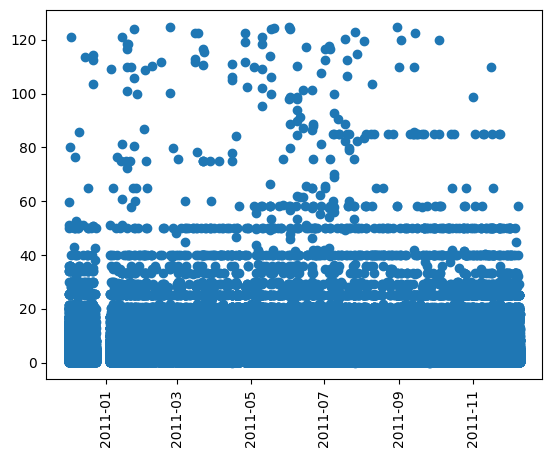

In [35]:
data_quantile = data[data['UnitPrice'] < 125]
plt.scatter(x=data_quantile.index, y=data_quantile['UnitPrice'])
plt.xticks(rotation=90)

In [36]:
data_quantile.describe()

,Quantity,UnitPrice
count,529361.000000,529361.000000
mean,10.555237,3.306499
std,155.632810,4.006631
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,124.870000


Looks like our data is almost ready for modelling.<br>
We performed a clean up, we removed outliers that were disturbing the balance of our dataset, we removed invalid records.<br>
Now our data looks much better! and it doesn't lose it's value.

Visually checking distribution of numeric features

<Axes: ylabel='Density'>

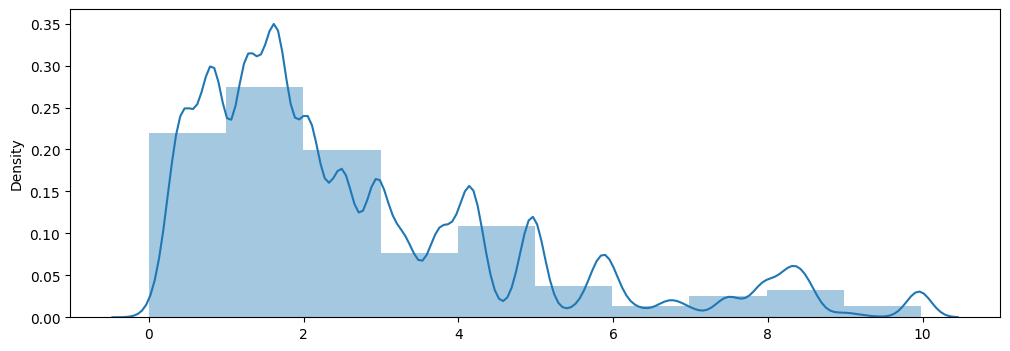

In [37]:
plt.figure(figsize=(12,4))
sns.distplot(data_quantile[data_quantile['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10)

<Axes: ylabel='Density'>

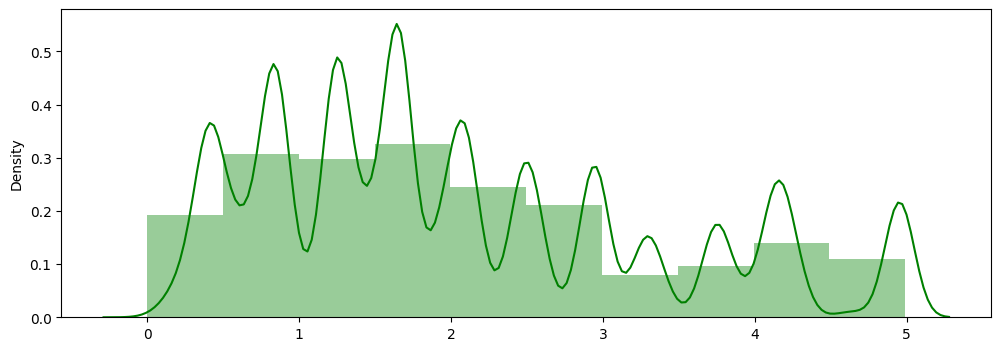

In [38]:
plt.figure(figsize=(12,4))
sns.distplot(data_quantile[data_quantile['UnitPrice'] < 5]['UnitPrice'].values, kde=True, bins=10, color='green')

From these histograms, we can see that the vast majority of items sold in this store have a low price range - 0 to 3 pounds.

<Axes: xlabel='Quantity', ylabel='Density'>

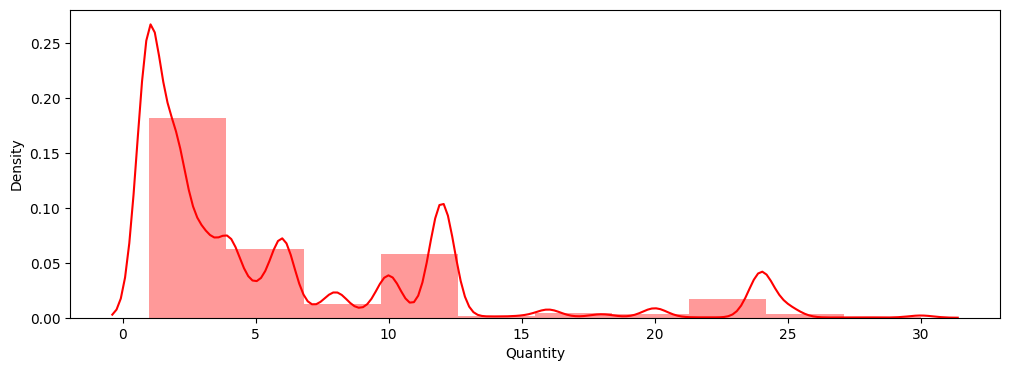

In [39]:
plt.figure(figsize=(12,4))
sns.distplot(data_quantile[data_quantile['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')

<Axes: xlabel='Quantity', ylabel='Density'>

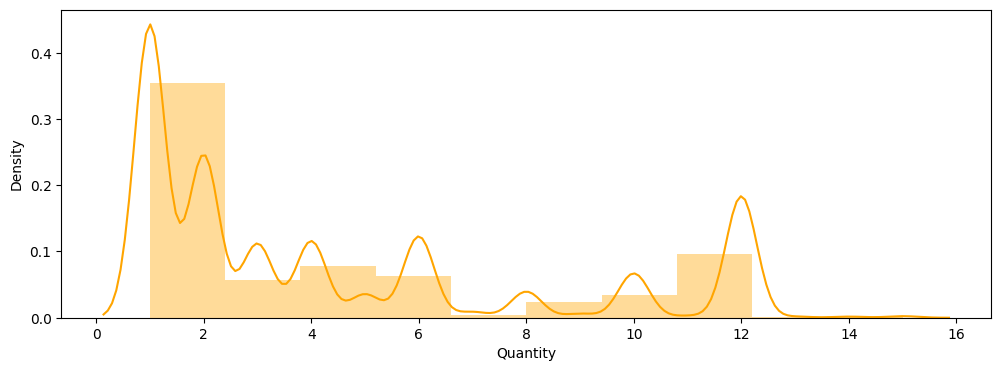

In [40]:
plt.figure(figsize=(12,4))
sns.distplot(data_quantile[data_quantile['Quantity'] <= 15]['Quantity'], kde=True, bins=10, color='orange')

From these histograms we that people bought normally 1-5 items or 10-12<br>
Maybe there was some kind of offers for sets?

<Axes: xlabel='UnitPrice', ylabel='Density'>

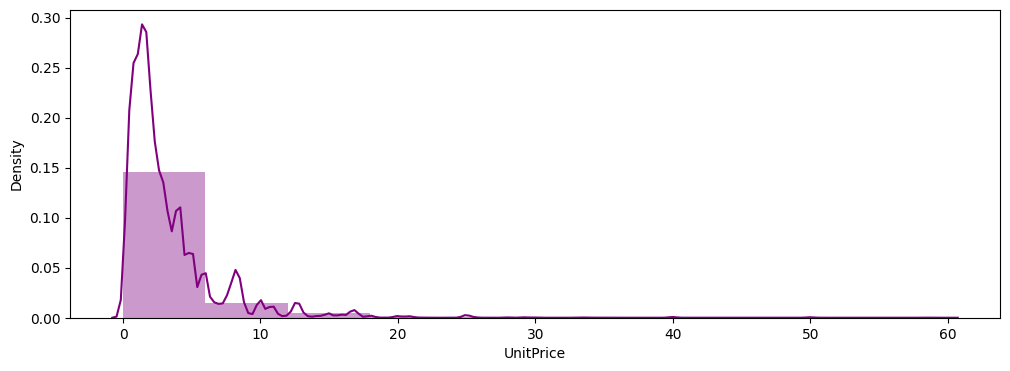

In [41]:
plt.figure(figsize=(12,4))
sns.distplot(data_quantile[data_quantile['UnitPrice'] < 60]['UnitPrice'], kde=True, bins=10, color='purple')

<Axes: xlabel='UnitPrice', ylabel='Density'>

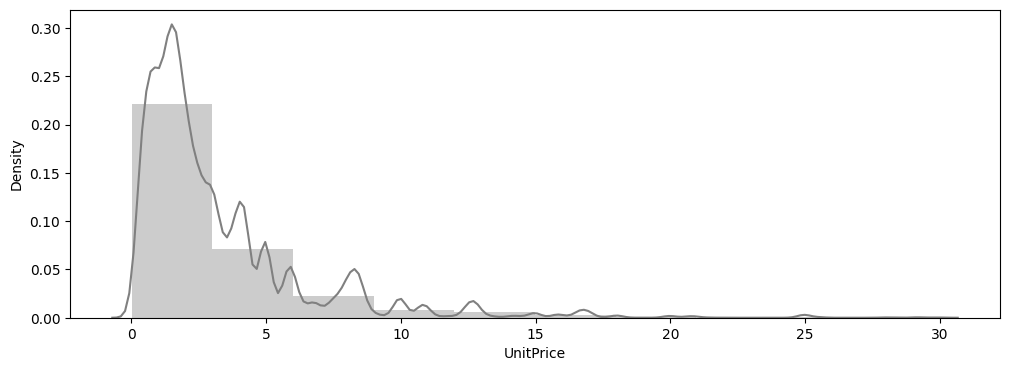

In [42]:
plt.figure(figsize=(12,4))
sns.distplot(data_quantile[data_quantile['UnitPrice'] < 30]['UnitPrice'], kde=True, bins=10, color='grey')

From these histograms, we can understand that majority of sales per order were in the range 1-15 pounds each.

Analysing sales over time

In [43]:
data_ts = data[['UnitPrice']]
data_ts.head()

,UnitPrice
InvoiceDate,
2010-12-01 08:26:00,2.55
2010-12-01 08:26:00,3.39
2010-12-01 08:26:00,2.75
2010-12-01 08:26:00,3.39
2010-12-01 08:26:00,3.39


As we can see every invoice has its own timestamp (definitely based on the time the order was made).<br>
We can resample time data by, for example, weeks, and try to see if there are any patterns in our sales.

<Axes: xlabel='InvoiceDate'>

<Figure size 1800x600 with 0 Axes>

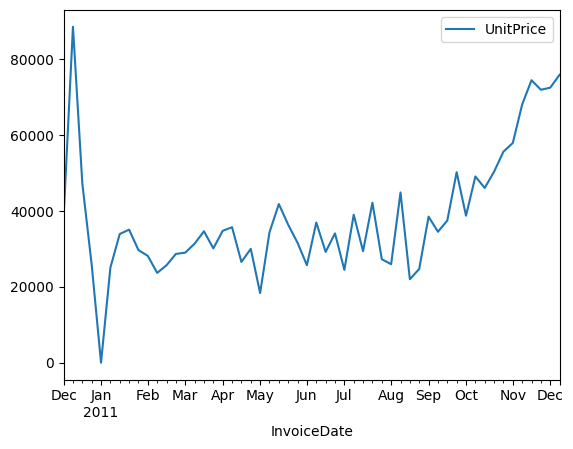

In [44]:
plt.figure(figsize=(18,6))
data_resample = data_ts.resample('W').sum()
data_resample.plot()

That week with 0 sales in January looks suspicious, let's check it closer.

In [45]:
data_resample['12-2010':'01-2011']

,UnitPrice
InvoiceDate,
2010-12-05,38224.49
2010-12-12,88540.65
2010-12-19,47278.94
2010-12-26,25860.39
2011-01-02,0.00
2011-01-09,25072.03
2011-01-16,33919.09
2011-01-23,35064.34
2011-01-30,29676.45


Now it makes sense - possibly, during the New Year holidays period the store was closed and didn't process orders, that's why they didn't make any sales.

Preparing data for modeling and feature creation<br>

Now comes the most fun part of the project - building a model.<br>
To do this we will need to create a few more additional features to make our model more sophisticated.

In [46]:
data_clean = data[data['UnitPrice'] < 15]
data_clean.describe()

,Quantity,UnitPrice
count,520395.000000,520395.000000
mean,10.707578,2.978730
std,156.962876,2.669826
min,1.000000,0.001000
25%,1.000000,1.250000
50%,4.000000,2.080000
75%,12.000000,4.130000
max,80995.000000,14.960000


In [47]:
data_clean.index

DatetimeIndex(['2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:28:00',
               '2010-12-01 08:28:00', '2010-12-01 08:34:00',
               ...
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=520395, freq=None)

Quantity per invoice feature<br>

A feature that could influence the sales output could be "Quantity per invoice". Let's find the data for this feature.

In [48]:
data_join = data_clean.groupby('InvoiceNo')[['Quantity']].sum()

In [49]:
data_join = data_join.reset_index()
data_join.head()

,InvoiceNo,Quantity
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3


In [50]:
data_clean['InvoiceDate'] = data_clean.index
data_clean = data_clean.merge(data_join, how='left', on='InvoiceNo')
data_clean = data_clean.rename(columns={'Quantity_x' : 'Quantity', 'Quantity_y' : 'QuantityInv'})
data_clean.tail(15)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv
520380,581587,22631,CIRCUS PARADE LUNCH BOX,12,1.95,France,2011-12-09 12:50:00,105
520381,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,1.65,France,2011-12-09 12:50:00,105
520382,581587,22555,PLASTERS IN TIN STRONGMAN,12,1.65,France,2011-12-09 12:50:00,105
520383,581587,22728,ALARM CLOCK BAKELIKE PINK,4,3.75,France,2011-12-09 12:50:00,105
520384,581587,22727,ALARM CLOCK BAKELIKE RED,4,3.75,France,2011-12-09 12:50:00,105
520385,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,3.75,France,2011-12-09 12:50:00,105
520386,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,3.75,France,2011-12-09 12:50:00,105
520387,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,1.95,France,2011-12-09 12:50:00,105
520388,581587,22629,SPACEBOY LUNCH BOX,12,1.95,France,2011-12-09 12:50:00,105
520389,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,4.15,France,2011-12-09 12:50:00,105


In [51]:
data_clean.describe()

,Quantity,UnitPrice,InvoiceDate,QuantityInv
count,520395.000000,520395.000000,520395,520395.000000
mean,10.707578,2.978730,2011-07-05 01:44:16.782867456,533.624937
min,1.000000,0.001000,2010-12-01 08:26:00,1.000000
25%,1.000000,1.250000,2011-03-28 13:28:00,152.000000
50%,4.000000,2.080000,2011-07-20 16:12:00,300.000000
75%,12.000000,4.130000,2011-10-19 13:58:00,567.000000
max,80995.000000,14.960000,2011-12-09 12:50:00,80995.000000
std,156.962876,2.669826,NaN,903.091973


In [52]:
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])

In [53]:
data_clean.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
UnitPrice             float64
Country                object
InvoiceDate    datetime64[ns]
QuantityInv             int64
dtype: object

Bucketing Quantity and UnitPrice features<br>
Based on the EDA done previously we can group these features into 6 buckets for Quantity and 5 for UnitePrice using the pandas.cut() method.

In [54]:
bins_q = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8), (8, 11), (11, 14), (15, 5000)])
data_clean['QuantityRange'] = pd.cut(data_clean['Quantity'], bins=bins_q)
bins_p = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 20)])
data_clean['PriceRange'] = pd.cut(data_clean['UnitPrice'], bins=bins_p)
data_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv,QuantityRange,PriceRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"


Extracting and bucketing dates<br>
We have noticed that depending on the season gifts sell differently:<br>

1. pick of sales is in the Q4
2. then it drastically drops in Q1 of the next year
3. and continues to grow till its new pick in Q4 again.<br>

From this observation, we can create another feature that could improve our model.

In [55]:
data_clean['Month'] = data_clean['InvoiceDate'].dt.month
data_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12


In [56]:
bins_d = pd.IntervalIndex.from_tuples([(0,3),(3,6),(6,9),(9,12)])
data_clean['DateRange'] = pd.cut(data_clean['Month'], bins=bins_d, labels=['q1','q2','q3','q4'])
data_clean.tail()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
520390,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,France,2011-12-09 12:50:00,105,"(11, 14]","(0, 1]",12,"(9, 12]"
520391,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,France,2011-12-09 12:50:00,105,"(5, 8]","(2, 3]",12,"(9, 12]"
520392,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,France,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520393,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,France,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520394,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,4.95,France,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"


Building a model

Splitting data into UK and non-UK<br>
We have to analyze these 2 datasets separately to have more standardized data for a model because there can be some patterns that work for other countries and do not for the UK or vice versa.<br>
Also a hypothesis to test - does the model built for the UK performs well on data for other countries?

In [57]:
data_uk = data_clean[data_clean['Country'] == 'United Kingdom']
data_abroad = data_clean[data_clean['Country'] != 'United Kingdom']

In [58]:
data_uk.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"


Extracting features and creating dummy variables

In [59]:
data_uk_model = data_uk[['UnitPrice', 'QuantityInv', 'QuantityRange', 'PriceRange', 'DateRange']]

In [60]:
data_uk_model.head()

,UnitPrice,QuantityInv,QuantityRange,PriceRange,DateRange
0,2.55,40,"(5, 8]","(2, 3]","(9, 12]"
1,3.39,40,"(5, 8]","(3, 4]","(9, 12]"
2,2.75,40,"(5, 8]","(2, 3]","(9, 12]"
3,3.39,40,"(5, 8]","(3, 4]","(9, 12]"
4,3.39,40,"(5, 8]","(3, 4]","(9, 12]"


In [61]:
data_uk_model_copy = data_uk_model.copy()
data_uk_model_copy = pd.get_dummies(data_uk_model_copy, columns=['QuantityRange'], prefix='qr')
data_uk_model_copy = pd.get_dummies(data_uk_model_copy, columns=['PriceRange'], prefix='pr')
data_uk_model_copy = pd.get_dummies(data_uk_model_copy, columns=['DateRange'], prefix='dr')
data_uk_model_copy.head()

,UnitPrice,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,2.55,40,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
1,3.39,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,2.75,40,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
3,3.39,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
4,3.39,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True


Scaling<br>
As the majority of our features are in the 0-1 range it would make sense to scale the "QuantityInv" feature too.
In general, scaling features is normally a good idea.

In [62]:
from sklearn.preprocessing import scale

data_uk_model_copy['QuantityInv'] = scale(data_uk_model_copy['QuantityInv'])

Train-Test Split<br>
Now we have to split our data into train-test data to be able to train our model and validate its capabilities.

In [63]:
y = data_uk_model_copy['UnitPrice']
X = data_uk_model_copy.drop(columns=['UnitPrice'])

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

Testing and validating different models<br>
We use GridSearch and CrossValidation to test three types of regressors:<br>
1. Linear
2. Decision Tree
3. RandomForest

In [65]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Linear Regression

In [73]:
# Initialize the model
linear_model = LinearRegression(fit_intercept=True)

# Fit the model to your data
linear_model.fit(X_train, y_train)

# Predict using the model
y_pred_linear = linear_model.predict(X_test)


Decision Tree

In [74]:
# Initialize the model
tree_model = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=2)

# Fit the model to your data
tree_model.fit(X_train, y_train)

# Predict using the model
y_pred_tree = tree_model.predict(X_test)


Random Forest

In [75]:
# Initialize the model
forest_model = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=2)

# Fit the model to your data
forest_model.fit(X_train, y_train)

# Predict using the model
y_pred_forest = forest_model.predict(X_test)

Gradient Boosting Regressor

In [86]:
# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model to your training data
gb_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred_gb = gb_regressor.predict(X_test)

Lasso Regressor Model

In [87]:
# Initialize the Lasso Regression model
lasso_regressor = Lasso(alpha=1.0, random_state=42)  # Adjust alpha as needed

# Fit the model to your training data
lasso_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lasso = lasso_regressor.predict(X_test)

Testing and validating

In [88]:
# Calculate metrics for Linear Regression
print("=== Linear Regression ===")
print(f"R2 Score: {r2_score(y_test, y_pred_linear)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_linear)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_linear)}")
print()

# Calculate metrics for Decision Tree
print("=== Decision Tree ===")
print(f"R2 Score: {r2_score(y_test, y_pred_tree)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_tree)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_tree)}")
print()

# Calculate metrics for Random Forest
print("=== Random Forest ===")
print(f"R2 Score: {r2_score(y_test, y_pred_forest)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_forest)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_forest)}")
print()

# Calculate and print metrics
print("=== Gradient Boosting Regressor ===")
print(f"R2 Score: {r2_score(y_test, y_pred_gb)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_gb)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gb)}")
print()

# Calculate and print metrics
print("=== Lasso Regression ===")
print(f"R2 Score: {r2_score(y_test, y_pred_lasso)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso)}")
print()

=== Linear Regression ===
R2 Score: 0.7550627023964682
MSE: 1.735768891612557
MAE: 0.715300133373285

=== Decision Tree ===
R2 Score: 0.7595972901103106
MSE: 1.7036341519588327
MAE: 0.6499699179900695

=== Random Forest ===
R2 Score: 0.7636692224318875
MSE: 1.674778058902783
MAE: 0.6466656250878114

=== Gradient Boosting Regressor ===
R2 Score: 0.7635900169614377
MSE: 1.6753393551732878
MAE: 0.6743652295208982

=== Lasso Regression ===
R2 Score: -3.8394511612249715e-05
MSE: 7.08685672861932
MAE: 1.9765376622226607

